# Benchmarking spatial mapping of cell types in the mouse brain

## Loading packages

In [2]:
import sys
import pickle
import scanpy as sc
import anndata
import numpy as np
import os
import pandas as pd

sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')

import cell2location

import matplotlib as mpl
from matplotlib import pyplot as plt

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
%config InlineBackend.figure_format='retina'

In [3]:
cell2location

<module 'cell2location' from '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/cell2location/__init__.py'>

## 1. Loading cell2location results <a name="loading"></a>

In [4]:
# read a previously trained LocationModel
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/'
sp_results_folder = f'{results_folder}'
sc_data_folder = f'/nfs/team205/vk7/sanger_projects/large_data/brains/mouse_allen/'

#run_name = 'LocationModelLinearDependentWMultiExperimentLocationBackgroundNormGeneAlpha_5experiments_121clusters_1393locations_13565genes_n_comb150_mean_var5_30k_y_s200_gl1'
run_name = 'LocationModelLinearDependentWMultiExperiment_121clusters_1393locations_13566genes_n_comb150_mean_var5_30k'

# path for saving figures
fig_path = f'{sp_results_folder}{run_name}/plots/figures/'
sc_figpath = sc.settings.figdir
sc.settings.figdir = f'{fig_path}'

sp_data_file = f'{sp_results_folder}{run_name}/sp.h5ad'
adata_vis = anndata.read(sp_data_file)

adata_vis.obs[adata_vis.uns['mod']['fact_names']] = adata_vis.uns['mod']['post_sample_q05']['spot_factors']

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
adata_snrna_raw = anndata.read(sc_data_folder + 'benchmark_SSp_PAR-POST-PRE.h5ad')
adata_snrna_raw.shape

(6948, 38377)

## 2. Extract gold standard annotations <a name="loading2"></a>

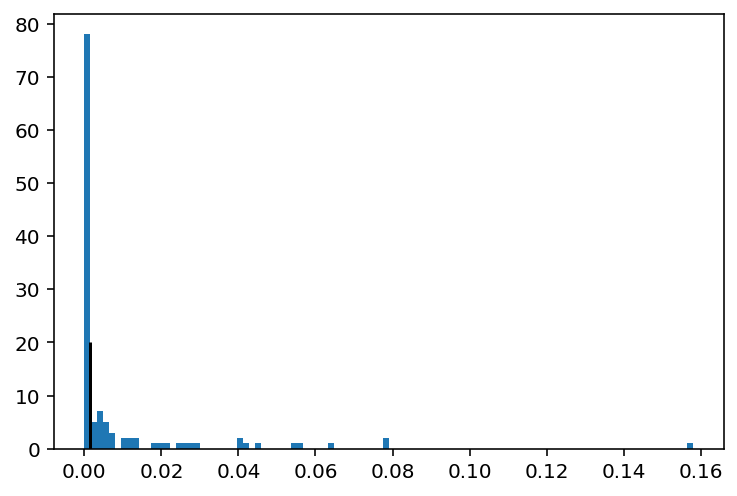

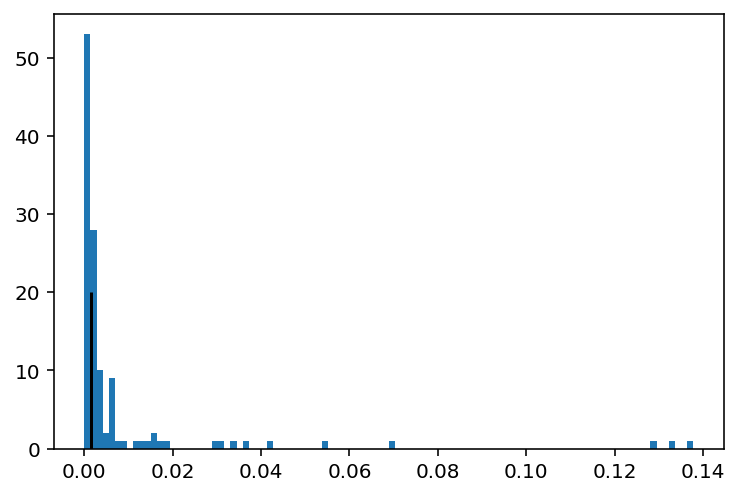

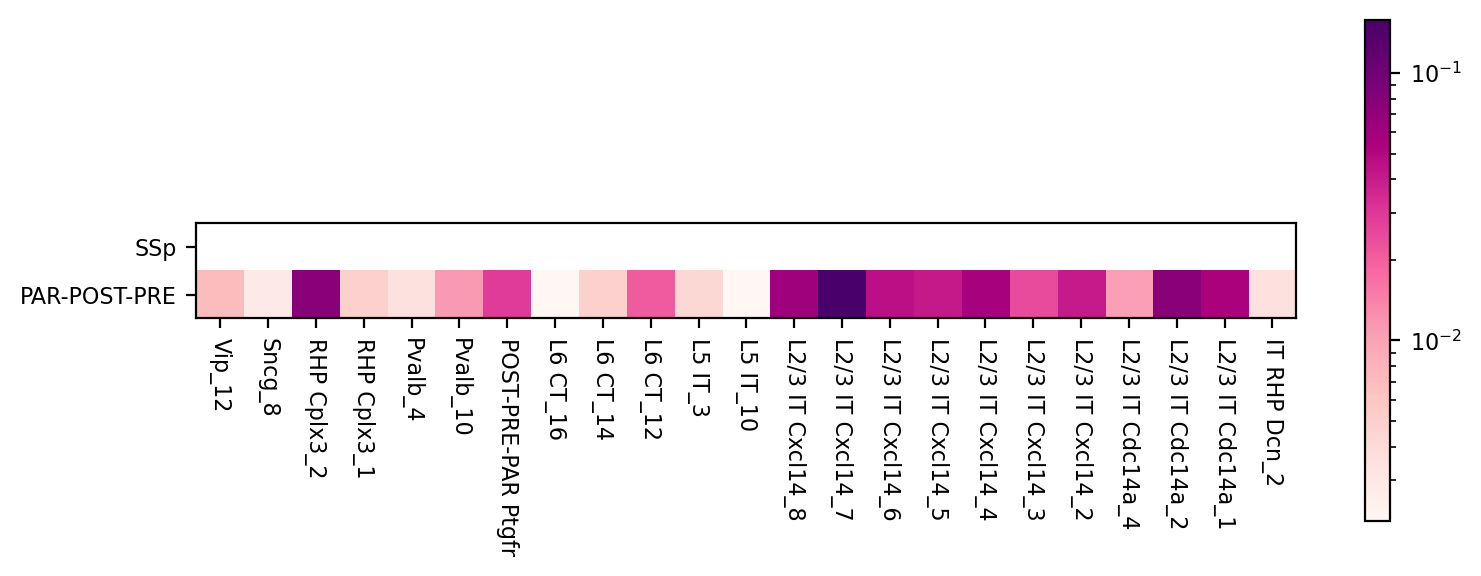

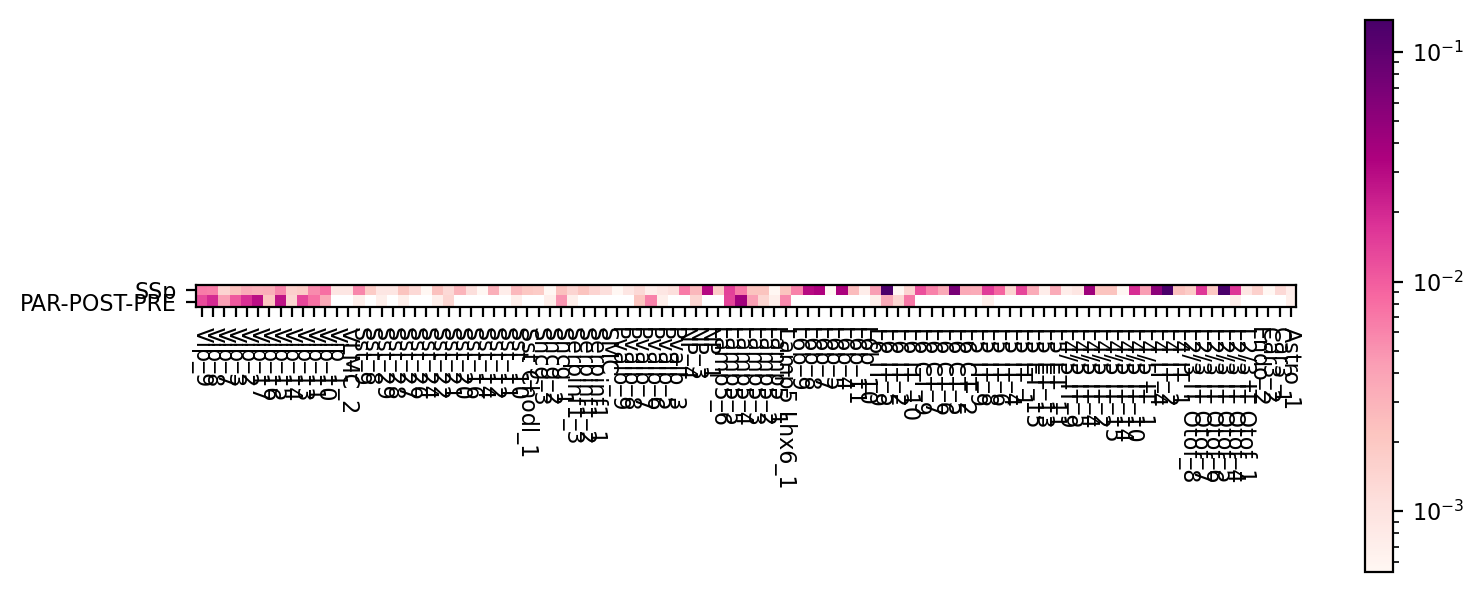

In [6]:
# the distribution of cell types across regions
lay = pd.DataFrame(index=adata_snrna_raw.obs['cluster_label'].unique())
for r in adata_snrna_raw.obs['region_label'].unique():
    ind = adata_snrna_raw.obs['region_label'].isin([r])
    lay[r] = adata_snrna_raw.obs.loc[ind, 'cluster_label'].value_counts()
    

lay = lay / lay.sum(0)

# selecting cell types very specific to PAR-POST-PRE compared to SSp
plt.hist(lay['PAR-POST-PRE'], bins=100);
plt.vlines(0.0015, 0, 20, color='black');
plt.show();

lay_PAR_POST_PRE = lay.loc[(lay['SSp'] == 0) & (lay['PAR-POST-PRE'] > 0.0005), :]
lay_PAR_POST_PRE = lay_PAR_POST_PRE.loc[np.sort(list(lay_PAR_POST_PRE.index)), :]

# selecting cell types very specific to PAR-POST-PRE compared to SSp
plt.hist(lay['SSp'], bins=100);
plt.vlines(0.0015, 0, 20, color='black');
plt.show();

lay_SSp_stringent = lay.loc[(lay['SSp'] > 0.0015) & (lay['PAR-POST-PRE'] == 0), :]
lay_SSp = lay.loc[(lay['SSp'] > 0.0005), :]
lay_SSp = lay_SSp.loc[np.sort(list(lay_SSp.index)), :]

mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'font.size': 8, 'axes.facecolor': "white"}):
    from cell2location.plt.plot_heatmap import clustermap
    clustermap(lay_PAR_POST_PRE.T, figure_size=(8, 3), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False)
    clustermap(lay_SSp.T, figure_size=(8, 3), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False)

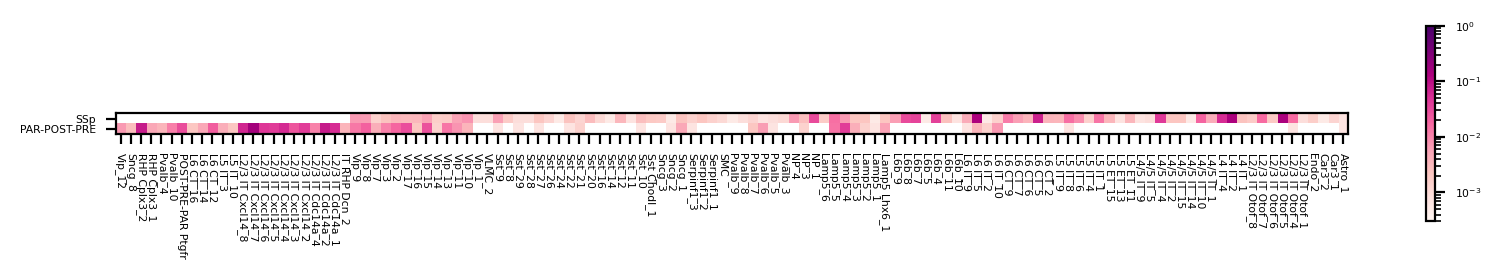

In [7]:
lay = pd.DataFrame(index=adata_snrna_raw.obs['cluster_label'].unique())
for r in adata_snrna_raw.obs['region_label'].unique():
    ind = adata_snrna_raw.obs['region_label'].isin([r])
    lay[r] = adata_snrna_raw.obs.loc[ind, 'cluster_label'].value_counts()
lay_binary_all = lay > 0
    
# reorder according to broad class
clearly_separated = [i for i in lay_SSp.index] + [i for i in lay_PAR_POST_PRE.index]
lay = lay.loc[clearly_separated, :]

#lay = lay.loc[lay.sum(1) > 15, :]
lay = lay / lay.sum(0)

lay_binary = lay > 0

mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'font.size': 3.9, 'axes.facecolor': "white"}):
    clustermap(lay.T, figure_size=(8.3, 1.3), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False,
               vmin=0.0003, vmax=1)
#     plt.savefig(f'{fig_path}Fig2J_suppl_PAR_POST_PRE_reference.pdf', bbox_inches='tight')
    plt.show()

In [8]:
lay_binary

,SSp,PAR-POST-PRE
Astro_1,True,True
Car3_1,True,False
Car3_2,True,False
Endo_2,True,False
L2/3 IT Otof_1,True,False
...,...,...
Pvalb_4,False,True
RHP Cplx3_1,False,True
RHP Cplx3_2,False,True
Sncg_8,False,True


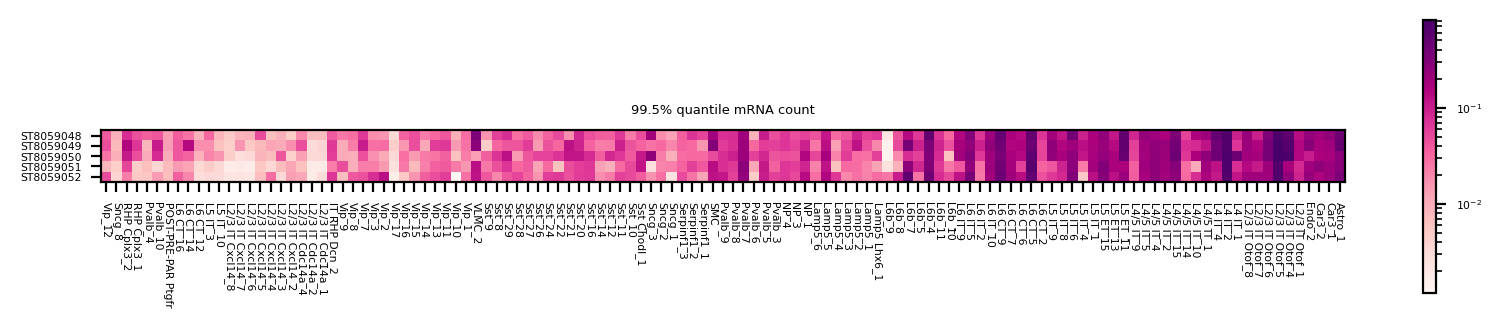

In [9]:
def quantile_by(adata, sel_clust = lay_binary.index.values,
                post_type = 'q05_spot_factors',
                by_col = 'sample', quantile=0.995):
    sel_clust_col = [f'{post_type}{i}' for i in sel_clust]
    infer_lay_df = adata.obs[sel_clust_col]
    infer_lay_df.columns = sel_clust
    infer_lay_df = (infer_lay_df.T / infer_lay_df.sum(1)).T
    infer_lay_df[infer_lay_df.isna()] = 0

    infer_lay = pd.DataFrame(index=sel_clust)
    for r in adata.obs[by_col].unique():
        ind = adata.obs[by_col].isin([r])
        # sum / mean of cell density across all spots within a region
        infer_lay[r] = np.quantile(infer_lay_df.loc[ind, :], quantile, axis=0)
    
    return infer_lay
    

infer_lay_nUMI = quantile_by(adata_vis, sel_clust = lay_binary.index.values,
                post_type = 'q05_spot_factors',
                by_col = 'sample')
gold_standard_lay = np.array([lay_binary['SSp'] for i in range(infer_lay_nUMI.shape[1])]).T

mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'font.size': 3.9, 'axes.facecolor': "white"}):
    clustermap(infer_lay_nUMI.T, figure_size=(8.3, 1.6), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False,
               #vmin=30, vmax=10000
              )
    plt.title('99.5% quantile mRNA count');
#     plt.savefig(f'{fig_path}Fig2J_suppl_PAR_POST_PRE_mapping.pdf', bbox_inches='tight')
    plt.show()

In [10]:
# call columns with q05_nUMI_factors as cell2location
sel_clust_col = [f'q05_spot_factors{i}' for i in lay_binary.index.values]
adata_vis.obs[[f'cell2location_{i}' for i in lay_binary.index.values]] = adata_vis.obs[sel_clust_col]

## Compare methods using PR-curves

Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


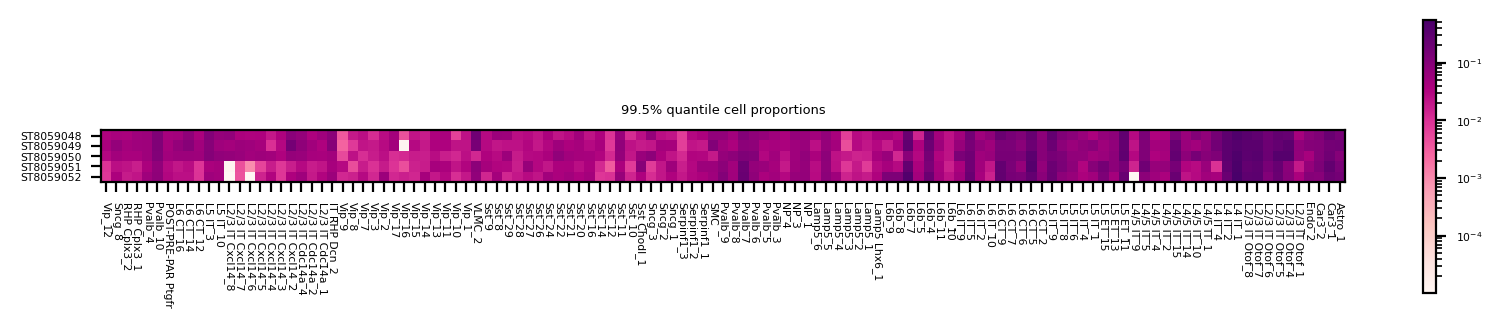

In [11]:
results_folder_st = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/allen_negative/'
RCTD = pd.read_csv(f'{results_folder_st}rctd/results_weights_121clusters_3246genes_6367genes.csv',
                   index_col='spot')
adata_vis = adata_vis[adata_vis.obs_names.isin(RCTD.index),:]

# compute cell proportions
RCTD = (RCTD.T / RCTD.sum(1)).T
RCTD = RCTD.loc[adata_vis.obs_names,:]

adata_vis.obs[[f'RCTD_{i}' for i in RCTD.columns]] = RCTD.values

RCTD = quantile_by(adata_vis, sel_clust = lay_binary.index.values,
                post_type = 'RCTD_',
                by_col = 'sample')

results = [RCTD]
names = ['RCTD']

mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'font.size': 3.9, 'axes.facecolor': "white"}):
    clustermap(RCTD.T, figure_size=(8.3, 1.6), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False,
               #vmin=0.001, vmax=1
              )
    plt.title('99.5% quantile cell proportions');
    #plt.savefig(f'{fig_path}Fig2J_suppl_PAR_POST_PRE_mapping.pdf', bbox_inches='tight')
    plt.show()

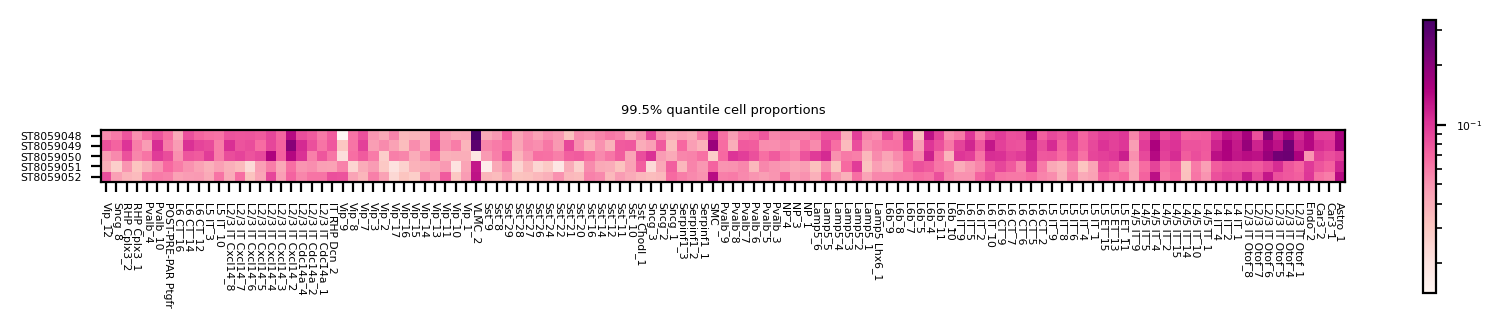

In [12]:
scvi_stereoscope = anndata.read(f'{results_folder_st}scvi_stereoscope/sp_20k.h5ad')

scvi_stereoscope = scvi_stereoscope.obsm['deconvolution'].copy()
scvi_stereoscope = (scvi_stereoscope.T / scvi_stereoscope.sum(1)).T
scvi_stereoscope = scvi_stereoscope.loc[adata_vis.obs_names,:]

adata_vis.obs[[f'scVI_Stereoscope_{i}' for i in scvi_stereoscope.columns]] = scvi_stereoscope.values

scvi_stereoscope = quantile_by(adata_vis, sel_clust = lay_binary.index.values,
                post_type = 'scVI_Stereoscope_',
                by_col = 'sample')

results = results + [scvi_stereoscope]
names = names + ['scVI_Stereoscope']

mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'font.size': 3.9, 'axes.facecolor': "white"}):
    clustermap(scvi_stereoscope.T, figure_size=(8.3, 1.6), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False,
               #vmin=0.001, vmax=1
              )
    plt.title('99.5% quantile cell proportions');
    #plt.savefig(f'{fig_path}Fig2J_suppl_PAR_POST_PRE_mapping.pdf', bbox_inches='tight')
    plt.show()

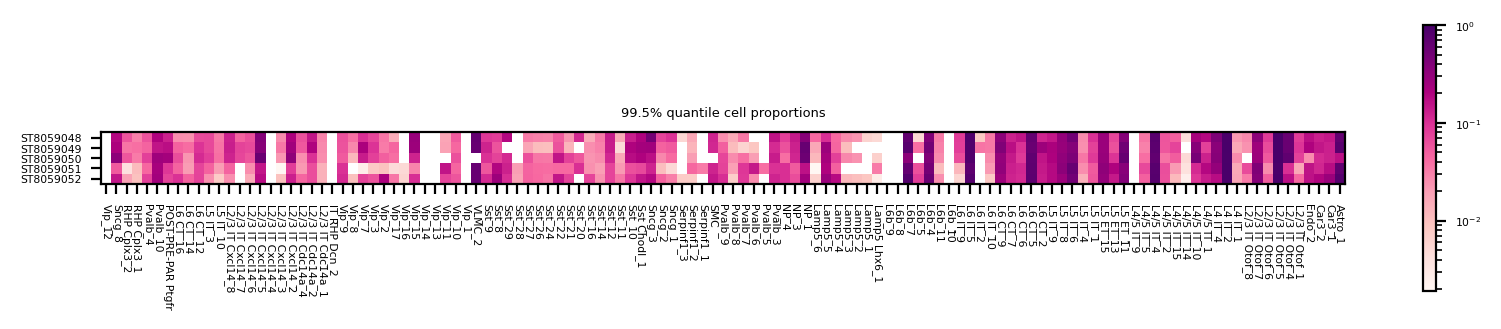

In [13]:
SeuratV3 = pd.read_csv(f'{results_folder_st}seurat_new/results_pca.csv',
                       index_col='spot')
SeuratV3 = SeuratV3.drop(columns=['prediction.score.max', 'Unnamed: 0', 'predicted.id'])
from re import sub
SeuratV3.columns = [sub('prediction.score.', '',i) for i in SeuratV3.columns]

seu_index = [sub(' ', '.',i) for i in infer_lay_nUMI.index]
seu_index = [sub('/', '.',i) for i in seu_index]
seu_index = [sub('-', '.',i) for i in seu_index]

SeuratV3 = SeuratV3[seu_index]
SeuratV3.columns = infer_lay_nUMI.index

# compute cell proportions
SeuratV3 = (SeuratV3.T / SeuratV3.sum(1)).T
SeuratV3 = SeuratV3.loc[adata_vis.obs_names,:]

adata_vis.obs[[f'Seurat_{i}' for i in SeuratV3.columns]] = SeuratV3.values

SeuratV3 = quantile_by(adata_vis, sel_clust = lay_binary.index.values,
                post_type = 'Seurat_',
                by_col = 'sample')

results = results + [SeuratV3]
names = names + ['Seurat']

mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'font.size': 3.9, 'axes.facecolor': "white"}):
    clustermap(SeuratV3.T, figure_size=(8.3, 1.6), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False,
               #vmin=0.001, vmax=1
              )
    plt.title('99.5% quantile cell proportions');
    #plt.savefig(f'{fig_path}Fig2J_suppl_PAR_POST_PRE_mapping.pdf', bbox_inches='tight')
    plt.show()

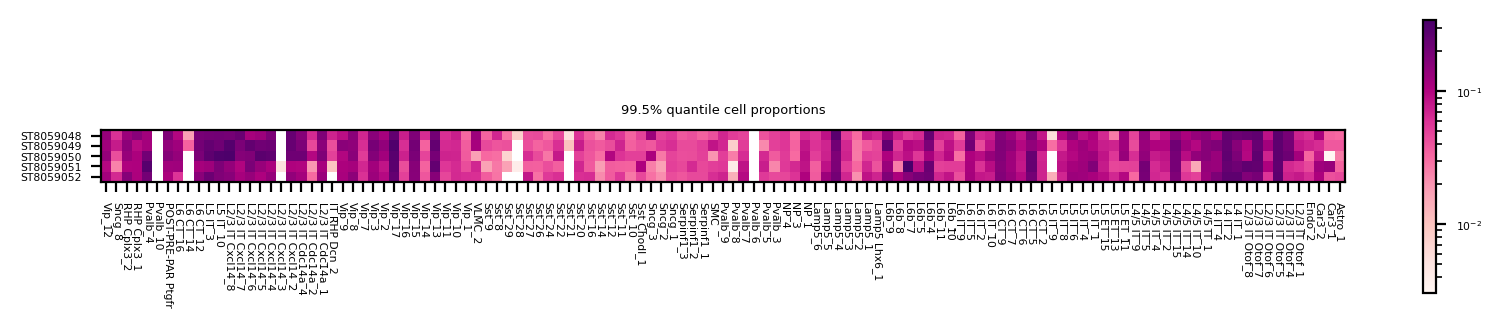

In [14]:
SPOTlight = pd.read_csv(f'{results_folder_st}SPOTlight/results_hvg5k.csv',
                       index_col='rn')
SPOTlight = SPOTlight.drop(columns=['res_ss'])
from re import sub

seu_index = [sub(' ', '.',i) for i in infer_lay_nUMI.index]
seu_index = [sub('/', '.',i) for i in seu_index]
seu_index = [sub('-', '.',i) for i in seu_index]
seu_index = [sub('_', '.',i) for i in seu_index]

SPOTlight = SPOTlight[seu_index]
SPOTlight.columns = infer_lay_nUMI.index

# compute cell proportions
SPOTlight = (SPOTlight.T / SPOTlight.sum(1)).T
SPOTlight[SPOTlight.isna()] = 0

SPOTlight = SPOTlight.loc[adata_vis.obs_names,:]

adata_vis.obs[[f'SPOTlight_{i}' for i in SPOTlight.columns]] = SPOTlight.values

SPOTlight = quantile_by(adata_vis, sel_clust = lay_binary.index.values,
                post_type = 'SPOTlight_',
                by_col = 'sample')

results = results + [SPOTlight]
names = names + ['SPOTlight']

mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'font.size': 3.9, 'axes.facecolor': "white"}):
    clustermap(SPOTlight.T, figure_size=(8.3, 1.6), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False,
               #vmin=0.001, vmax=1
              )
    plt.title('99.5% quantile cell proportions');
    #plt.savefig(f'{fig_path}Fig2J_suppl_PAR_POST_PRE_mapping.pdf', bbox_inches='tight')
    plt.show()



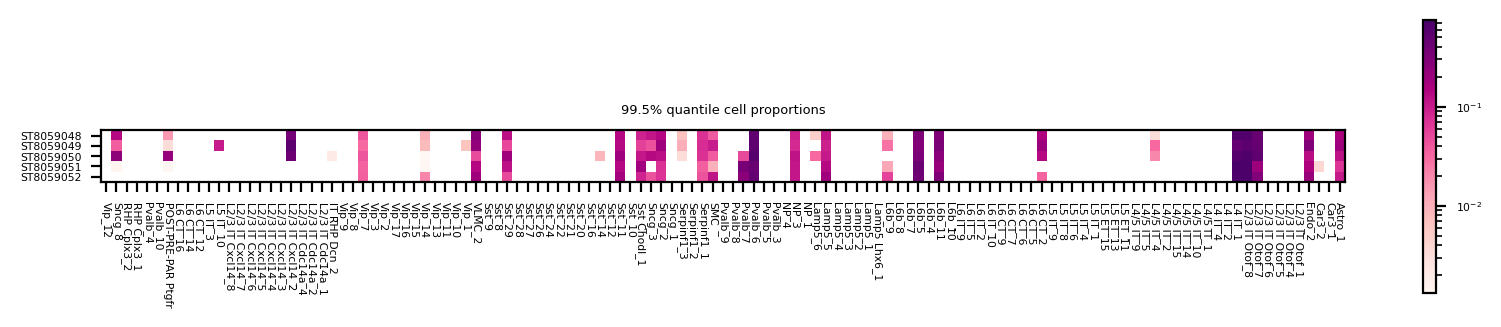

In [15]:
nnls = pd.read_csv(f'{results_folder_st}autogenes_models/coef_nnls_seed.csv', index_col=0).T

# compute cell proportions
nnls = (nnls.T / nnls.sum(1)).T
nnls[nnls.isna()] = 0

nnls = nnls.loc[adata_vis.obs_names,:]

adata_vis.obs[[f'NNSL_{i}' for i in nnls.columns]] = nnls.values

nnls = quantile_by(adata_vis, sel_clust = lay_binary.index.values,
                post_type = 'NNSL_',
                by_col = 'sample')

results = results + [nnls]
names = names + ['NNSL']

mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'font.size': 3.9, 'axes.facecolor': "white"}):
    clustermap(nnls.T, figure_size=(8.3, 1.6), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False,
               #vmin=0.001, vmax=1
              )
    plt.title('99.5% quantile cell proportions');
    #plt.savefig(f'{fig_path}Fig2J_suppl_PAR_POST_PRE_mapping.pdf', bbox_inches='tight')
    plt.show()

# Figure code

In [18]:
def flatten_df(df, method=None):
    df_list = []
    for c in df.columns:
        df_new = pd.DataFrame({'Proportion': df[c].values, 'Cell Type': df.index, 'Sample': c})
        df_list.append(df_new)
    df_merged = pd.concat(df_list)
    
    if method is not None:
        df_merged['Method'] = method
    
    return df_merged.reset_index(drop=True)

In [19]:
results_dict = {
    'cell2location': infer_lay_nUMI,
    'RCTD': RCTD,
    'SCVI_Stereoscope': scvi_stereoscope,
    'SeuratV3': SeuratV3,
    'SPOTlight': SPOTlight,
    'NNLS': nnls
}

flatten_results_dict = {k: flatten_df(v, method=k) for k, v in results_dict.items()}
results_df = pd.concat(list(flatten_results_dict.values())).reset_index(drop=True).fillna({'Proportion':0})
cortex_cell_types = list(lay_binary.index[lay_binary['SSp']])
results_df['Location'] = results_df['Cell Type'].apply(lambda x: 'Cortex' if x in cortex_cell_types else 'Hypo')

In [21]:
results_df['Proportion_log'] = np.log(results_df['Proportion'] + 0.01)

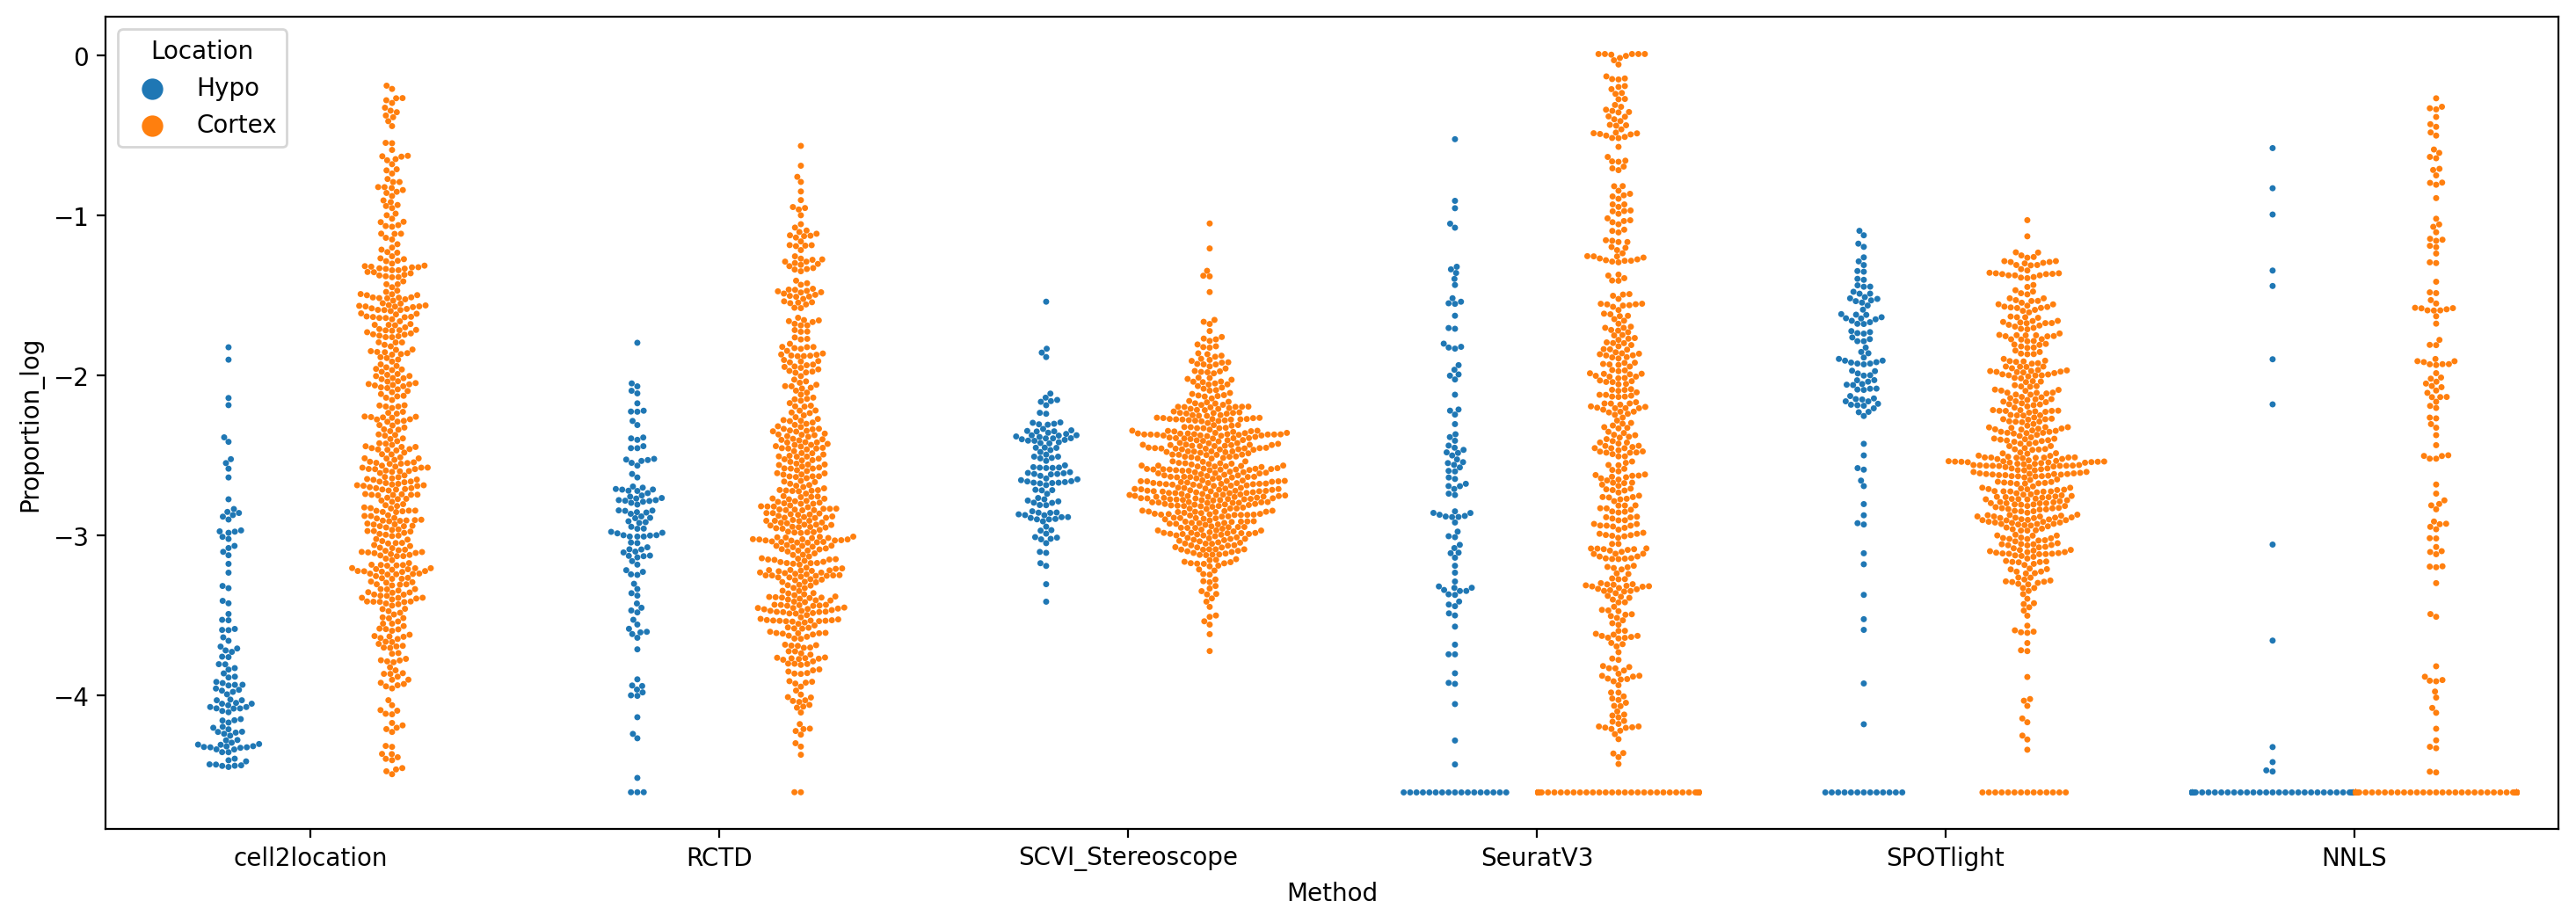

In [25]:
plt.figure(figsize=(18, 6))

ax = sns.swarmplot(x="Method", y="Proportion_log", hue="Location", data=results_df, dodge=True,
                  hue_order=['Hypo', 'Cortex'], size=2.5)

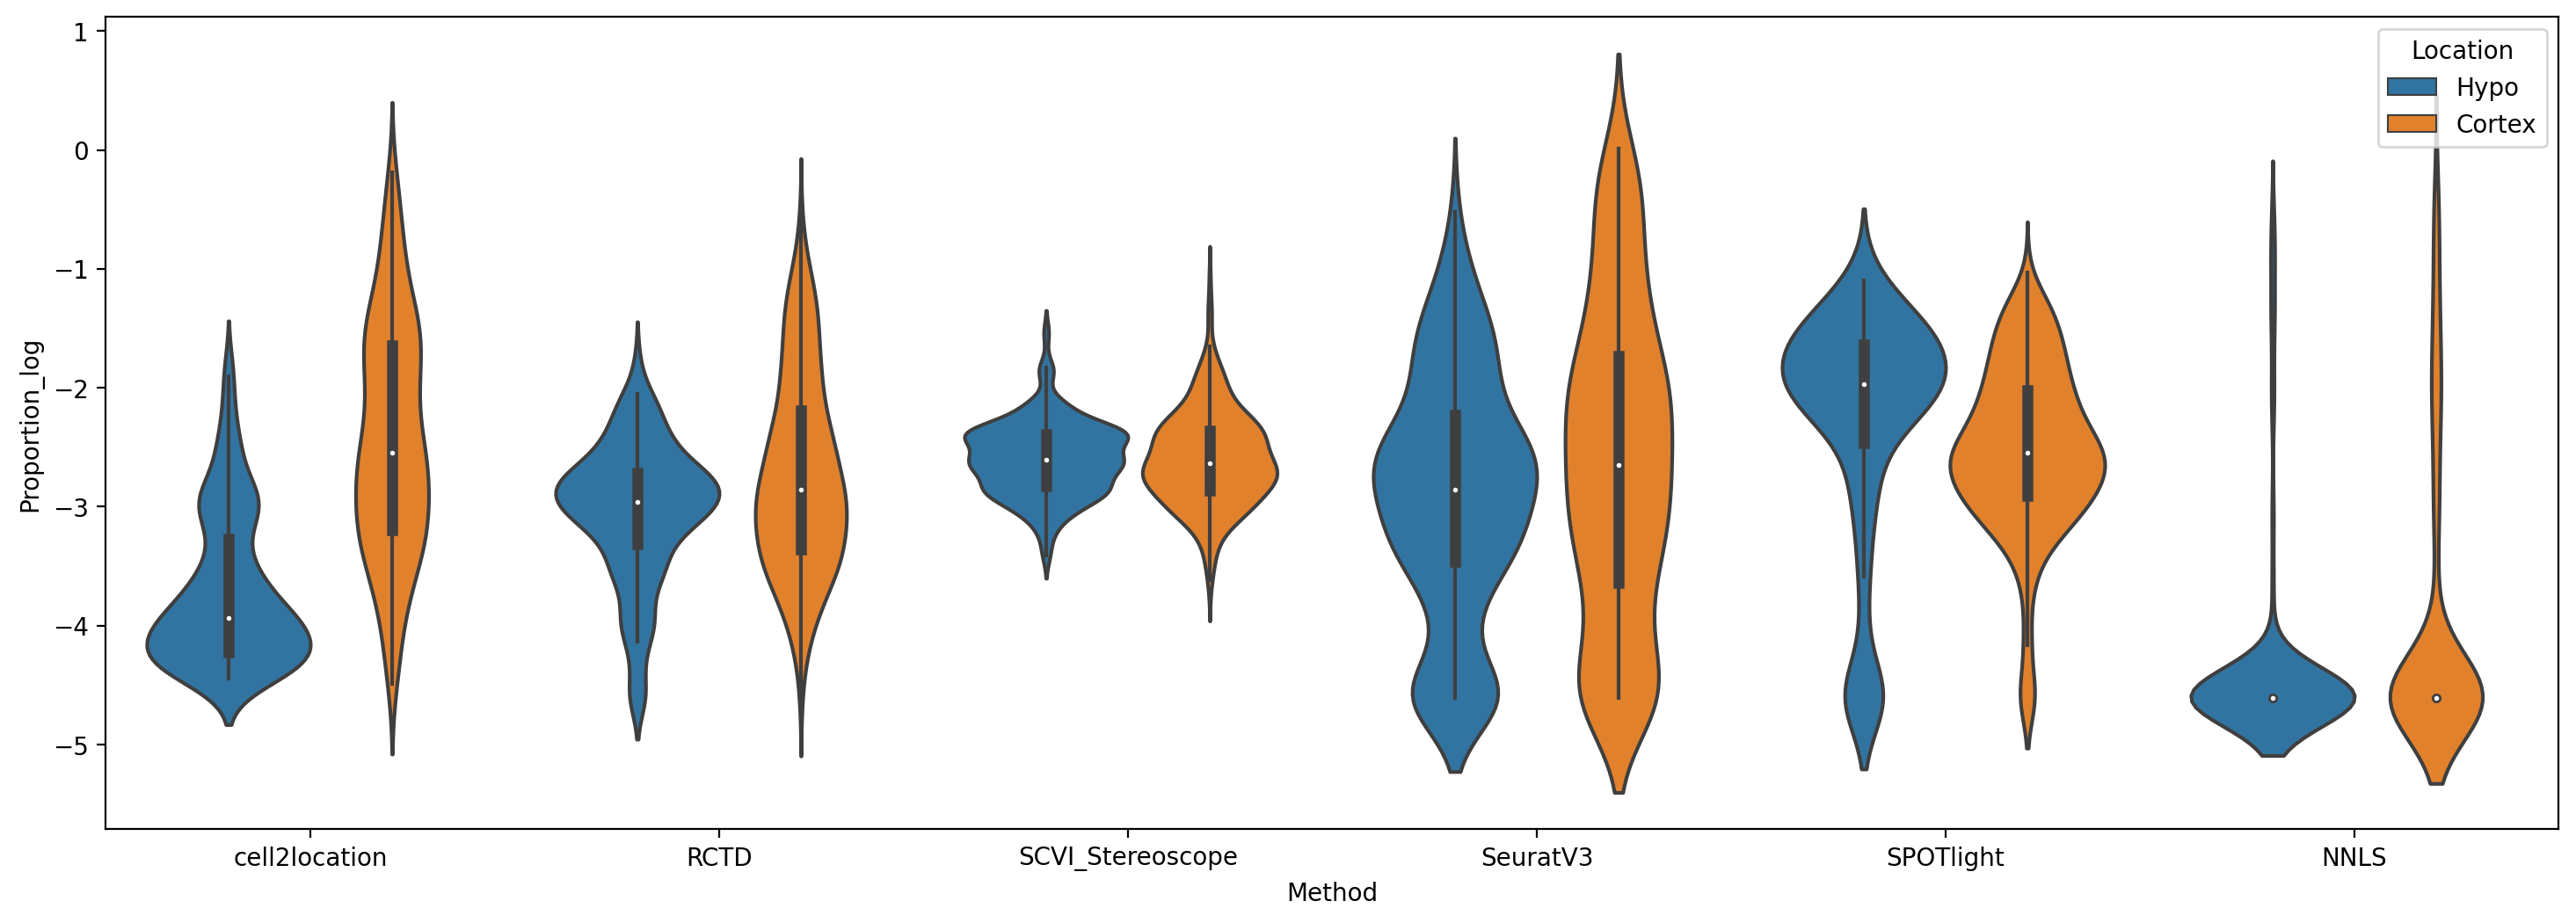

In [29]:
plt.figure(figsize=(18, 6))

ax = sns.violinplot(x="Method", y="Proportion_log", hue="Location", data=results_df, dodge=True,
                  hue_order=['Hypo', 'Cortex'], inner='box', bw=0.3)

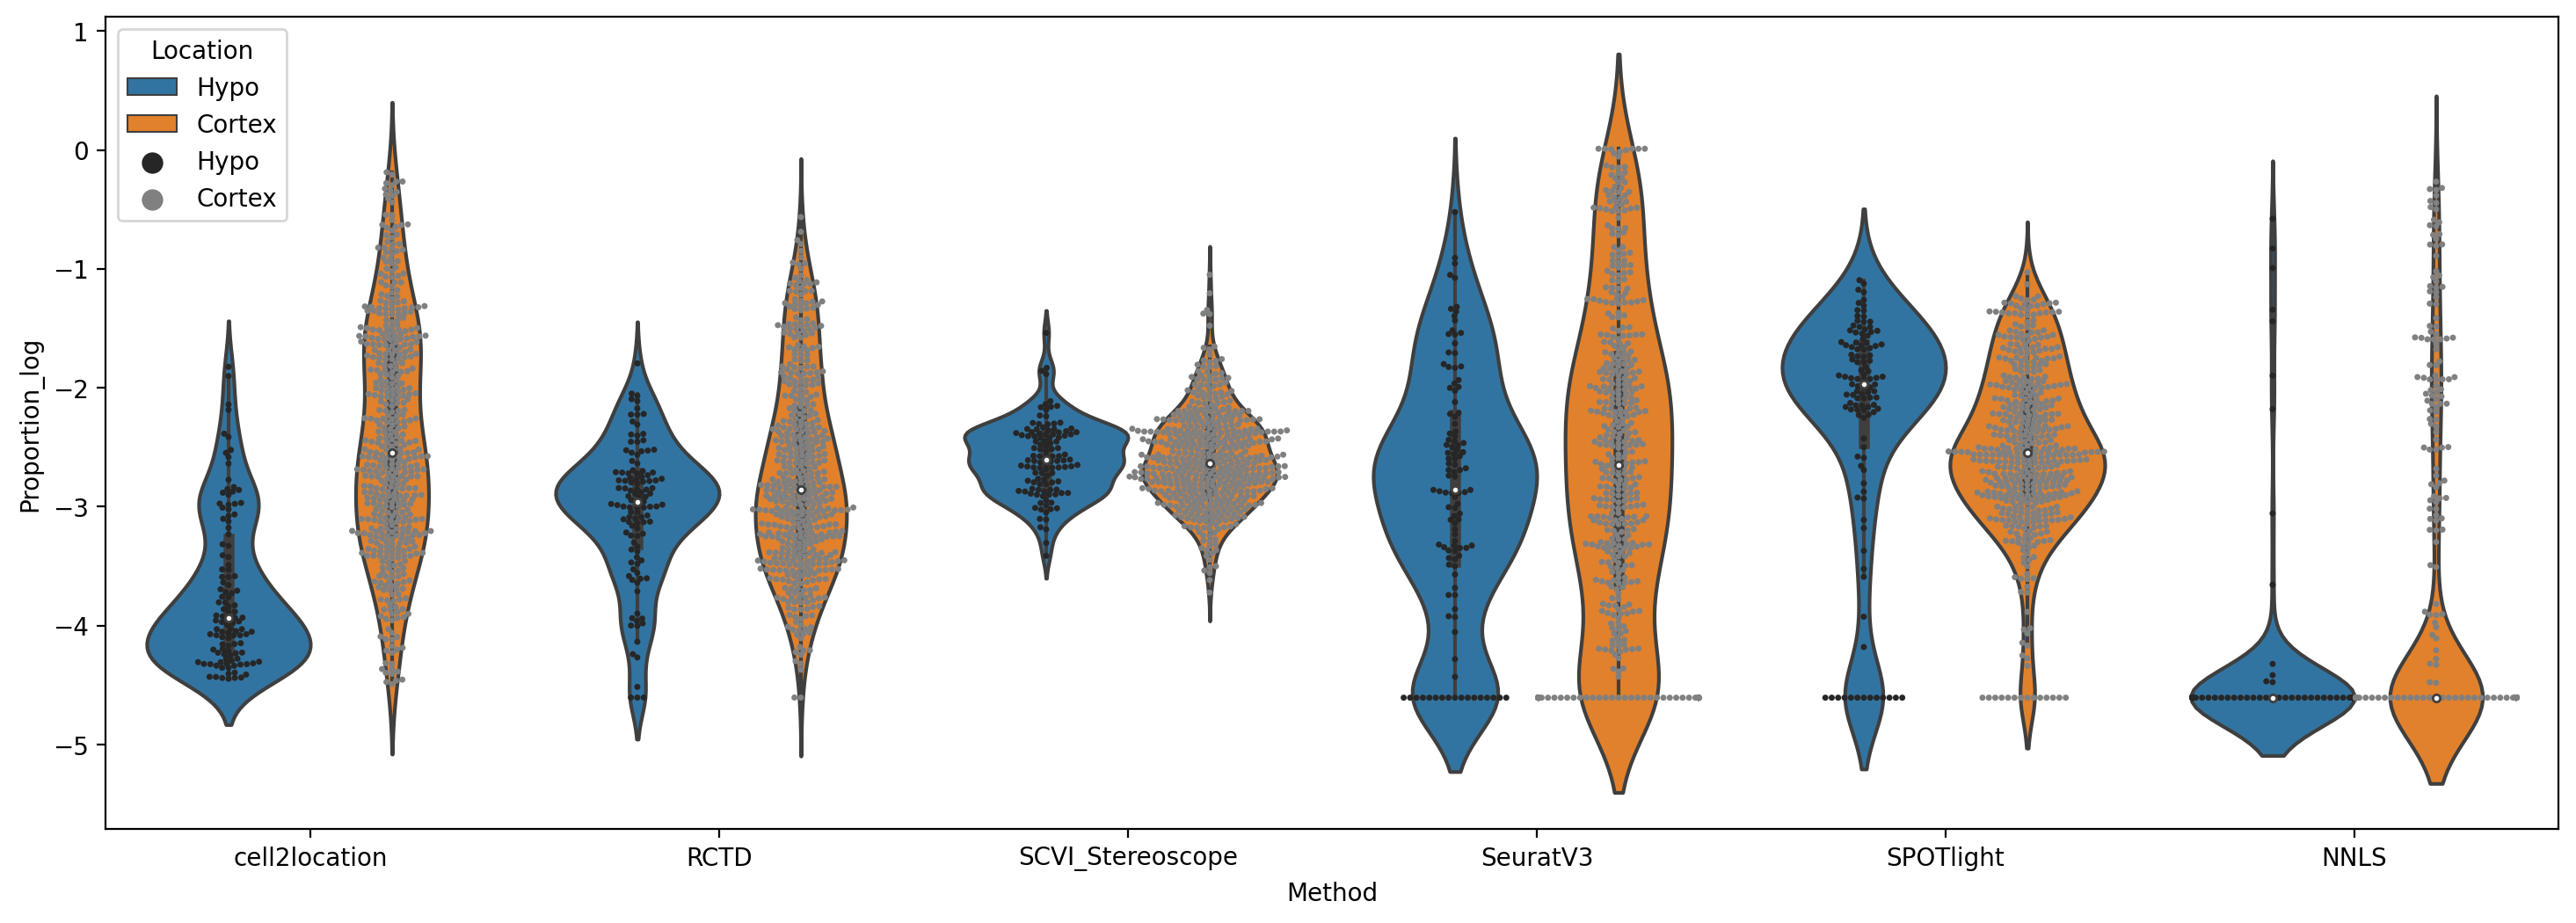

In [32]:
plt.figure(figsize=(18, 6))

ax = sns.swarmplot(x="Method", y="Proportion_log", hue="Location", data=results_df, dodge=True,
                  hue_order=['Hypo', 'Cortex'], size=2.5, color='grey')

ax = sns.violinplot(x="Method", y="Proportion_log", hue="Location", data=results_df, dodge=True,
                  hue_order=['Hypo', 'Cortex'], inner='box', bw=0.3)

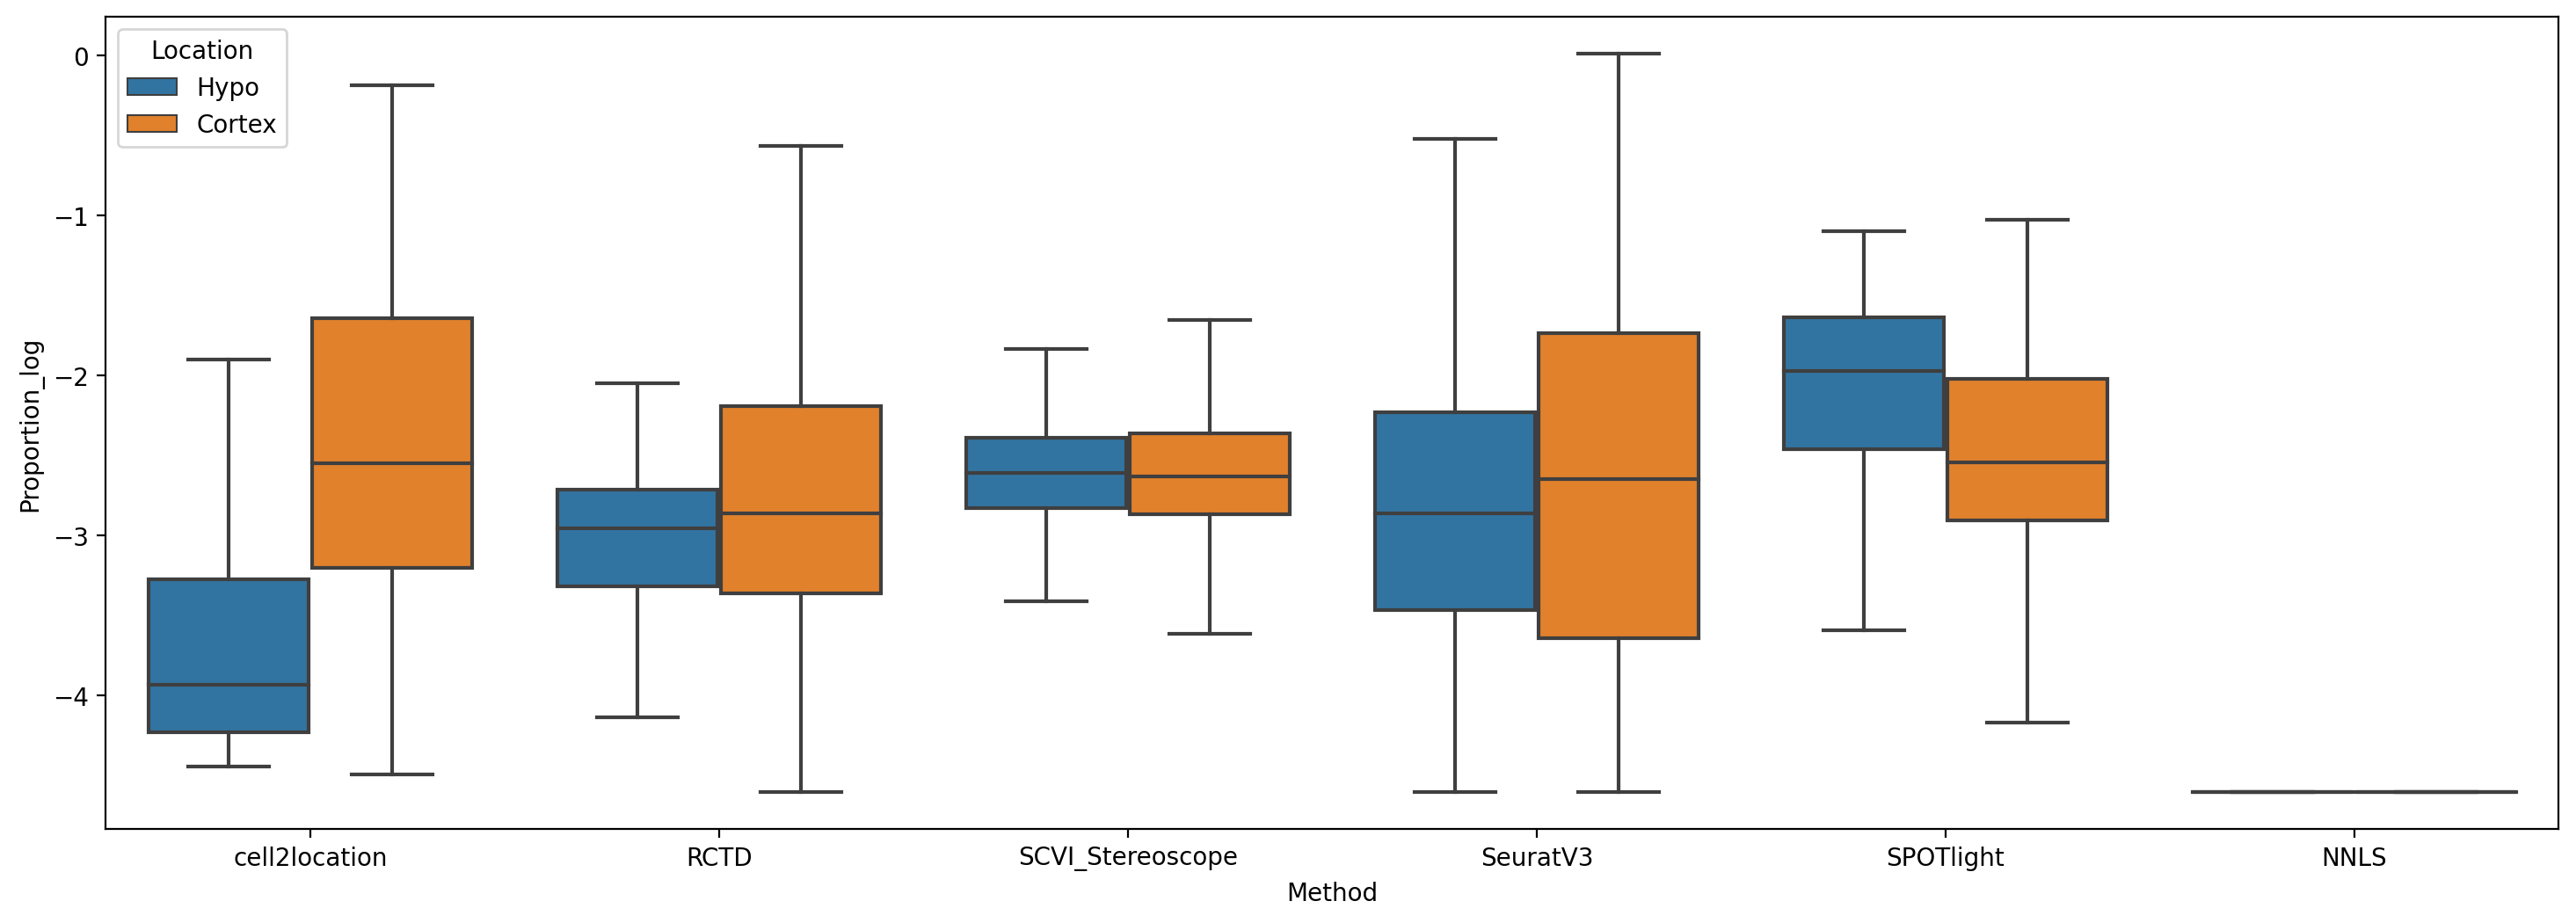

In [36]:
plt.figure(figsize=(18, 6))

ax = sns.boxplot(x="Method", y="Proportion_log", hue="Location", data=results_df, dodge=True,
                  hue_order=['Hypo', 'Cortex'], fliersize=0)

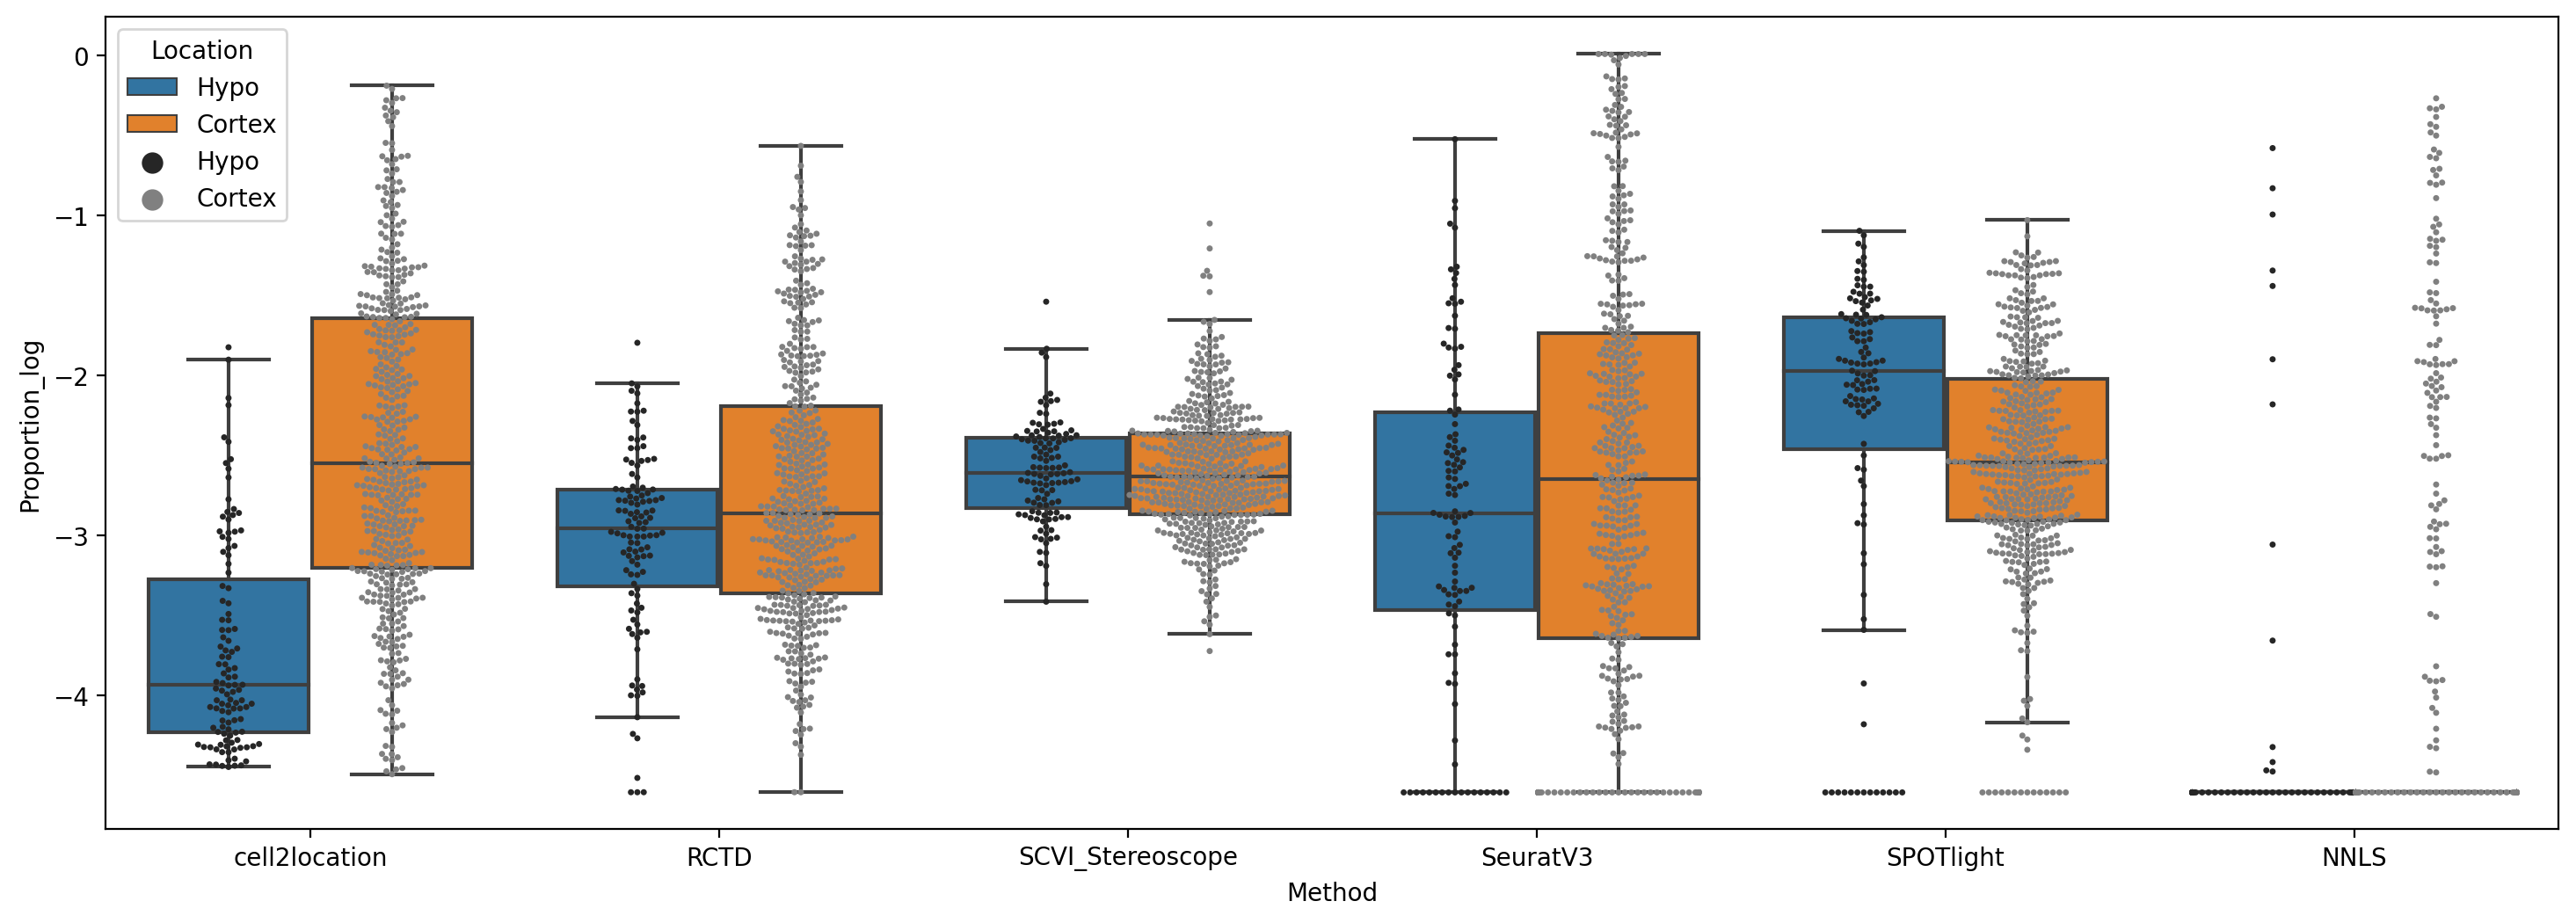

In [37]:
plt.figure(figsize=(18, 6))

ax = sns.swarmplot(x="Method", y="Proportion_log", hue="Location", data=results_df, dodge=True,
                  hue_order=['Hypo', 'Cortex'], size=2.5, color='grey')

ax = sns.boxplot(x="Method", y="Proportion_log", hue="Location", data=results_df, dodge=True,
                  hue_order=['Hypo', 'Cortex'], fliersize=0)

In [43]:
!chmod 777 benchmark_analysis_violins_cortex.ipynb

In [45]:
!pwd

/nfs/team283/as56
